# 1. 사전 준비

## 1.1 라이브러리 import

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from glob import glob
import glob
from typing import *
from IPython.display import Image as IPImage
from sklearn.model_selection import train_test_split
import random
import os
import shutil
from PIL import Image as Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import ConcatDataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

## 1.2 구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

from_file_path = '/content/drive/MyDrive/real-and-fake-face-detection-master.zip'  # 복사할 파일
to_file_path = '/content/real-and-fake-face-detection-master.zip'  # 복사 위치

# 파일 복사
shutil.copy(from_file_path, to_file_path)

# 압축 해제
with zipfile.ZipFile(to_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/') # 압축 해제 위치

# 2. DataFrame 생성

In [ ]:
# 파일 경로 가져오기 및 DataFrame 생성
image_paths = glob.glob('/content/real-and-fake-face-detection-master/dataset/training/*/*.jpg')
df = pd.DataFrame({'path': image_paths})

# 레이블 추출 및 CSV 저장
df['label'] = df['path'].apply(lambda x: os.path.basename(os.path.dirname(x)))
df.to_csv('train_data.csv', index=False)

# 학습 데이터셋 불러오기
origin_train_df = pd.read_csv('train_data.csv')
print(origin_train_df)

                                                   path label
0     /content/real-and-fake-face-detection-master/d...  fake
1     /content/real-and-fake-face-detection-master/d...  fake
2     /content/real-and-fake-face-detection-master/d...  fake
3     /content/real-and-fake-face-detection-master/d...  fake
4     /content/real-and-fake-face-detection-master/d...  fake
...                                                 ...   ...
1432  /content/real-and-fake-face-detection-master/d...  real
1433  /content/real-and-fake-face-detection-master/d...  real
1434  /content/real-and-fake-face-detection-master/d...  real
1435  /content/real-and-fake-face-detection-master/d...  real
1436  /content/real-and-fake-face-detection-master/d...  real

[1437 rows x 2 columns]


In [ ]:
# 파일 경로 가져오기 및 DataFrame 생성
test_image_paths = glob.glob('/content/real-and-fake-face-detection-master/dataset/test/*/*.jpg')
tdf = pd.DataFrame({'path': test_image_paths})

# 레이블 추출
tdf['label'] = tdf['path'].apply(lambda x: os.path.basename(os.path.dirname(x)))

# CSV 파일로 저장
tdf.to_csv('test_data.csv', index=False)

## 2.1 검증 데이터셋 생성

In [ ]:
# train 데이터셋을 8:2로 분할
train_df, valid_df = train_test_split(
    origin_train_df,
    test_size=0.2,
    random_state=0,
    shuffle=True,
    stratify=origin_train_df["label"],
)

# 3. 딥러닝 모델 구조

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        img = Image.open(img_name).convert('RGB')
        label = 0 if self.dataframe.iloc[idx, 1] == 'real' else 1
        if self.transform:
            img = self.transform(img)
        return img, label

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
def compute_overall_mean_std(dfs):
    all_pixels = {0: [], 1: [], 2: []}

    for df in dfs:
        for index, row in df.iterrows():
            img_path = row['path']
            img = Image.open(img_path)
            img_np = np.array(img)

            for i in range(3): # RGB 채널
                channel_pixels = img_np[:, :, i].ravel().tolist()  # 각 채널의 모든 픽셀 값을 수집
                all_pixels[i].extend(channel_pixels)

    means = [np.mean(all_pixels[i]) for i in range(3)]
    stds = [np.std(all_pixels[i]) for i in range(3)]

    return means, stds

# 미리 계산해둔 값 사용
channel_means = [193.67807472479592, 111.60517909723688, 118.44033090803525]
channel_stds = [63.00208387441839, 87.1299016633704, 71.00312754293988]

print("Overall Data: Mean -", channel_means, "Std -", channel_stds)

Overall Data: Mean - [193.67807472479592, 111.60517909723688, 118.44033090803525] Std - [63.00208387441839, 87.1299016633704, 71.00312754293988]


In [ ]:
# 채널 평균 및 표준편차를 0~1 사이의 값으로 정규화
normalized_channel_means = [x / 255 for x in channel_means]
normalized_channel_stds = [x / 255 for x in channel_stds]

# 배치 사이즈 설정
batch_size = 32

# 학습용 데이터 증강 변환 정의
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 약간 큰 크기로 리사이즈
    transforms.RandomCrop((224, 224)),  # 랜덤 크롭
    transforms.RandomHorizontalFlip(),  # 랜덤 수평 뒤집기
    transforms.RandomRotation(10),  # 랜덤 회전 (-10도에서 10도 사이)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색상 변조
    transforms.ToTensor(),
    transforms.Normalize(mean=normalized_channel_means, std=normalized_channel_stds),
])

# 검증 및 테스트용 변환 정의
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalized_channel_means, std=normalized_channel_stds),
])

# 데이터셋 로딩
train_dataset = CustomDataset(dataframe=train_df, transform=train_transform)
valid_dataset = CustomDataset(dataframe=valid_df, transform=eval_transform)
test_dataset = CustomDataset(dataframe=tdf, transform=eval_transform)

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

ResNet18 모델 로드 및 파인튜닝

In [ ]:
# 사전 학습된 ResNet18 모델 불러오기
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# 모델의 마지막 완전 연결 계층(fc) 2로 설정
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2),
)

# 교차 엔트로피 손실 함수 초기화
criterion = nn.CrossEntropyLoss()
# 최적화 알고리즘으로 Adam 사용
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# 전체 훈련 횟수 설정
num_epochs = 50
# 최고 검증 정확도 초기화
best_val_acc = 0.0
# 얼리 스타핑을 위한 조건 설정 (성능 향상이 없을 때 몇 에포크까지 기다릴지)
patience = 5
# 연속적으로 성능 향상이 없는 에포크 수를 추적
no_improve = 0

# 훈련 및 검증 손실을 추적하기 위한 리스트
train_losses = []
valid_losses = []

# 정해진 훈련 횟수만큼 반복
for epoch in range(num_epochs):

    model.train() # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0

     # 훈련 데이터 로더를 통해 배치를 반복
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # 이전 반복에서 계산된 그래디언트를 초기화
        outputs = model(inputs) # 모델에 입력을 전달하여 출력을 계산
        loss = criterion(outputs, labels) # 손실 함수를 사용하여 손실 계산
        loss.backward() # 손실에 대한 그래디언트를 계산
        optimizer.step() # 옵티마이저를 사용하여 모델의 가중치를 업데이트

        running_loss += loss.item()  # 총 손실을 누적

        _, predicted = torch.max(outputs.data, 1) # 예측 결과 계산
        total_train += labels.size(0) # 전체 레이블 수 업데이트
        correct_train += (predicted == labels).sum().item() # 정확한 예측 수 업데이트

    # 에포크별 훈련 정확도 및 손실 계산
    train_acc = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validate
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = correct_val / total_val
    val_loss = running_val_loss / len(valid_loader)

    # 손실 기록
    train_losses.append(train_loss)
    valid_losses.append(val_loss)

    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    # 최고 검증 정확도를 갱신하고 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_after.pth')
        no_improve = 0
    else:
        no_improve += 1 # 성능 향상이 없으면 no_improve 카운터 증가
        if no_improve >= patience:  # 설정한 얼리 스타핑 patience에 도달하면 학습을 중단합니다.
            print("Early stopping")
            break

print('Finished Training')

Epoch 1/50: 100%|██████████| 36/36 [00:20<00:00,  1.73it/s]


Train Loss: 2.5904, Train Accuracy: 0.2315, Validation Loss: 2.4905, Validation Accuracy: 0.3958


Epoch 2/50: 100%|██████████| 36/36 [00:25<00:00,  1.43it/s]


Train Loss: 2.2806, Train Accuracy: 0.3647, Validation Loss: 2.3109, Validation Accuracy: 0.4479


Epoch 3/50: 100%|██████████| 36/36 [00:21<00:00,  1.69it/s]


Train Loss: 1.9846, Train Accuracy: 0.4430, Validation Loss: 2.1797, Validation Accuracy: 0.4583


Epoch 4/50: 100%|██████████| 36/36 [00:21<00:00,  1.68it/s]


Train Loss: 1.7448, Train Accuracy: 0.5196, Validation Loss: 2.0844, Validation Accuracy: 0.4688


Epoch 5/50: 100%|██████████| 36/36 [00:22<00:00,  1.61it/s]


Train Loss: 1.5133, Train Accuracy: 0.5901, Validation Loss: 2.0787, Validation Accuracy: 0.4757


Epoch 6/50: 100%|██████████| 36/36 [00:21<00:00,  1.70it/s]


Train Loss: 1.3439, Train Accuracy: 0.6171, Validation Loss: 1.9479, Validation Accuracy: 0.4965


Epoch 7/50: 100%|██████████| 36/36 [00:21<00:00,  1.66it/s]


Train Loss: 1.1993, Train Accuracy: 0.6597, Validation Loss: 1.8444, Validation Accuracy: 0.5243


Epoch 8/50: 100%|██████████| 36/36 [00:21<00:00,  1.69it/s]


Train Loss: 1.0671, Train Accuracy: 0.6841, Validation Loss: 1.7243, Validation Accuracy: 0.5382


Epoch 9/50: 100%|██████████| 36/36 [00:21<00:00,  1.68it/s]


Train Loss: 0.9594, Train Accuracy: 0.7102, Validation Loss: 1.6567, Validation Accuracy: 0.5451


Epoch 10/50: 100%|██████████| 36/36 [00:20<00:00,  1.74it/s]


Train Loss: 0.8712, Train Accuracy: 0.7380, Validation Loss: 1.6162, Validation Accuracy: 0.5486


Epoch 11/50: 100%|██████████| 36/36 [00:24<00:00,  1.46it/s]


Train Loss: 0.7830, Train Accuracy: 0.7581, Validation Loss: 1.4419, Validation Accuracy: 0.5694


Epoch 12/50: 100%|██████████| 36/36 [00:21<00:00,  1.69it/s]


Train Loss: 0.7370, Train Accuracy: 0.7833, Validation Loss: 1.3590, Validation Accuracy: 0.6007


Epoch 13/50: 100%|██████████| 36/36 [00:24<00:00,  1.46it/s]


Train Loss: 0.6801, Train Accuracy: 0.7789, Validation Loss: 1.3065, Validation Accuracy: 0.6076


Epoch 14/50: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s]


Train Loss: 0.6389, Train Accuracy: 0.7824, Validation Loss: 1.2797, Validation Accuracy: 0.5972


Epoch 15/50: 100%|██████████| 36/36 [00:21<00:00,  1.67it/s]


Train Loss: 0.5814, Train Accuracy: 0.8077, Validation Loss: 1.2190, Validation Accuracy: 0.6111


Epoch 16/50: 100%|██████████| 36/36 [00:21<00:00,  1.65it/s]


Train Loss: 0.5473, Train Accuracy: 0.8181, Validation Loss: 1.1827, Validation Accuracy: 0.6146


Epoch 17/50: 100%|██████████| 36/36 [00:21<00:00,  1.69it/s]


Train Loss: 0.5007, Train Accuracy: 0.8259, Validation Loss: 1.1831, Validation Accuracy: 0.6215


Epoch 18/50: 100%|██████████| 36/36 [00:20<00:00,  1.76it/s]


Train Loss: 0.4688, Train Accuracy: 0.8538, Validation Loss: 1.2015, Validation Accuracy: 0.6215


Epoch 19/50: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Train Loss: 0.4464, Train Accuracy: 0.8512, Validation Loss: 1.1585, Validation Accuracy: 0.6111


Epoch 20/50: 100%|██████████| 36/36 [00:20<00:00,  1.72it/s]


Train Loss: 0.4001, Train Accuracy: 0.8747, Validation Loss: 1.0384, Validation Accuracy: 0.6250


Epoch 21/50: 100%|██████████| 36/36 [00:22<00:00,  1.60it/s]


Train Loss: 0.3904, Train Accuracy: 0.8808, Validation Loss: 1.1218, Validation Accuracy: 0.6181


Epoch 22/50: 100%|██████████| 36/36 [00:20<00:00,  1.75it/s]


Train Loss: 0.3634, Train Accuracy: 0.8877, Validation Loss: 1.1540, Validation Accuracy: 0.6042


Epoch 23/50: 100%|██████████| 36/36 [00:25<00:00,  1.39it/s]


Train Loss: 0.3389, Train Accuracy: 0.8930, Validation Loss: 1.0441, Validation Accuracy: 0.6319


Epoch 24/50: 100%|██████████| 36/36 [00:21<00:00,  1.71it/s]


Train Loss: 0.3340, Train Accuracy: 0.8921, Validation Loss: 1.0246, Validation Accuracy: 0.6319


Epoch 25/50: 100%|██████████| 36/36 [00:21<00:00,  1.67it/s]


Train Loss: 0.3068, Train Accuracy: 0.9025, Validation Loss: 1.1526, Validation Accuracy: 0.6250


Epoch 26/50: 100%|██████████| 36/36 [00:20<00:00,  1.72it/s]


Train Loss: 0.3027, Train Accuracy: 0.9025, Validation Loss: 1.0732, Validation Accuracy: 0.6389


Epoch 27/50: 100%|██████████| 36/36 [00:20<00:00,  1.79it/s]


Train Loss: 0.2964, Train Accuracy: 0.9034, Validation Loss: 1.0930, Validation Accuracy: 0.6319


Epoch 28/50: 100%|██████████| 36/36 [00:22<00:00,  1.61it/s]


Train Loss: 0.2563, Train Accuracy: 0.9295, Validation Loss: 1.0194, Validation Accuracy: 0.6424


Epoch 29/50: 100%|██████████| 36/36 [00:21<00:00,  1.70it/s]


Train Loss: 0.2407, Train Accuracy: 0.9286, Validation Loss: 1.0697, Validation Accuracy: 0.6458


Epoch 30/50: 100%|██████████| 36/36 [00:22<00:00,  1.62it/s]


Train Loss: 0.2452, Train Accuracy: 0.9225, Validation Loss: 1.0263, Validation Accuracy: 0.6458


Epoch 31/50: 100%|██████████| 36/36 [00:21<00:00,  1.68it/s]


Train Loss: 0.2278, Train Accuracy: 0.9295, Validation Loss: 0.9972, Validation Accuracy: 0.6667


Epoch 32/50: 100%|██████████| 36/36 [00:21<00:00,  1.65it/s]


Train Loss: 0.2025, Train Accuracy: 0.9347, Validation Loss: 1.0442, Validation Accuracy: 0.6528


Epoch 33/50: 100%|██████████| 36/36 [00:21<00:00,  1.68it/s]


Train Loss: 0.1962, Train Accuracy: 0.9399, Validation Loss: 1.0002, Validation Accuracy: 0.6562


Epoch 34/50: 100%|██████████| 36/36 [00:24<00:00,  1.47it/s]


Train Loss: 0.1780, Train Accuracy: 0.9495, Validation Loss: 1.1711, Validation Accuracy: 0.6424


Epoch 35/50: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]


Train Loss: 0.1724, Train Accuracy: 0.9513, Validation Loss: 1.1543, Validation Accuracy: 0.6319


Epoch 36/50: 100%|██████████| 36/36 [00:21<00:00,  1.68it/s]


Train Loss: 0.1587, Train Accuracy: 0.9495, Validation Loss: 1.1018, Validation Accuracy: 0.6701


Epoch 37/50: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s]


Train Loss: 0.1627, Train Accuracy: 0.9487, Validation Loss: 1.1344, Validation Accuracy: 0.6632


Epoch 38/50: 100%|██████████| 36/36 [00:21<00:00,  1.69it/s]


Train Loss: 0.1700, Train Accuracy: 0.9417, Validation Loss: 1.0772, Validation Accuracy: 0.6562


Epoch 39/50: 100%|██████████| 36/36 [00:22<00:00,  1.61it/s]


Train Loss: 0.1760, Train Accuracy: 0.9521, Validation Loss: 1.1412, Validation Accuracy: 0.6424


Epoch 40/50: 100%|██████████| 36/36 [00:21<00:00,  1.70it/s]


Train Loss: 0.1477, Train Accuracy: 0.9513, Validation Loss: 1.0538, Validation Accuracy: 0.6736


Epoch 41/50: 100%|██████████| 36/36 [00:21<00:00,  1.68it/s]


Train Loss: 0.1278, Train Accuracy: 0.9695, Validation Loss: 1.1215, Validation Accuracy: 0.6597


Epoch 42/50: 100%|██████████| 36/36 [00:21<00:00,  1.69it/s]


Train Loss: 0.1458, Train Accuracy: 0.9504, Validation Loss: 1.1955, Validation Accuracy: 0.6493


Epoch 43/50: 100%|██████████| 36/36 [00:20<00:00,  1.74it/s]


Train Loss: 0.1366, Train Accuracy: 0.9591, Validation Loss: 1.1705, Validation Accuracy: 0.6562


Epoch 44/50: 100%|██████████| 36/36 [00:21<00:00,  1.70it/s]


Train Loss: 0.1216, Train Accuracy: 0.9582, Validation Loss: 1.1973, Validation Accuracy: 0.6562


Epoch 45/50: 100%|██████████| 36/36 [00:24<00:00,  1.50it/s]


Train Loss: 0.1068, Train Accuracy: 0.9721, Validation Loss: 1.1878, Validation Accuracy: 0.6458
Early stopping
Finished Training


In [ ]:
model.load_state_dict(torch.load('best_model_before.pth'))
model.eval()

<ipython-input-19-29aff42fe851>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_before.pth'))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Validate
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predicted.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_predictions = np.concatenate(all_predictions)

conf_mat = confusion_matrix(all_labels, all_predictions)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

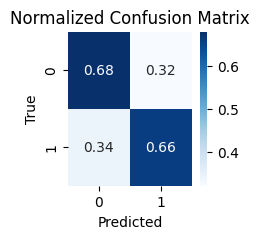

In [ ]:
plt.figure(figsize=(2, 2))
sns.heatmap(conf_mat_normalized, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()
# real = 0 // fake = 1

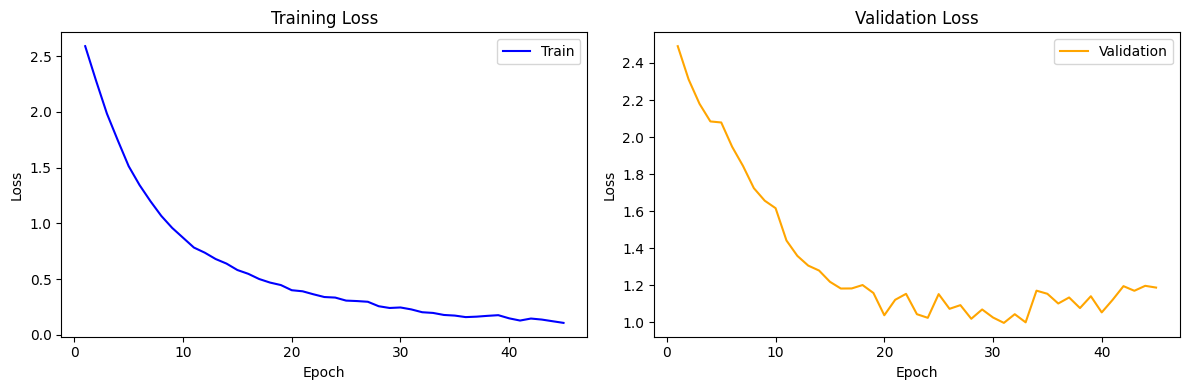

In [ ]:
actual_epochs = len(train_losses)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Train Loss 그래프
axes[0].plot(range(1, actual_epochs + 1), train_losses, label='Train', color='blue')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()

# Validation Loss 그래프
axes[1].plot(range(1, actual_epochs + 1), valid_losses, label='Validation', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Validation Loss')
axes[1].legend()

# 그래프 출력
plt.tight_layout()
plt.show()

Enter location of image to predict: /content/real-and-fake-face-detection-master/dataset/face_pred/버츄얼 휴먼4.jpg


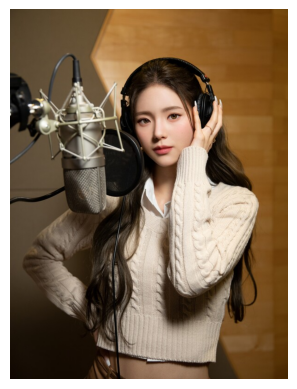

Prediction: Real


In [ ]:
def predict_image(model, image_path):
    # Model to eval mode
    model.eval()

    # Image preprocessing
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load and transform image
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)

    # Display image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Move image tensor to the same device as the model
    image_tensor = image_tensor.to(next(model.parameters()).device)  # Move to model's device

    # Prediction
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

    # Interpret result
    result = "Real" if predicted.item() == 1 else "Fake"

    print(f"Prediction: {result}")
    return result


image_path = input("Enter location of image to predict: ")
prediction = predict_image(model, image_path)